In [2]:
import numpy as np
from sklearn.model_selection import KFold

In [1]:
import h5py,numpy as np,os
path = '../data/fold0_noFIR.mat'
data = h5py.File(path, 'r')

x_train = data['trainX'][:].astype('float32')
x_train = np.expand_dims(x_train.transpose(),1)

x_val = data['valX'][:].astype('float32')
x_val = np.expand_dims(x_val.transpose(),1)

y_train = data['trainY'][:].astype('int32')
y_train = y_train.transpose()
y_train = y_train[:,0]
y_train[y_train<0] = 0

y_val = data['valY'][:].astype('int32')
y_val = y_val.transpose()
y_val = y_val[:,0]
y_val[y_val<0] = 0

val_parts = data['val_parts'][:].astype('int32').squeeze(0)
domain = np.array([x-97 for x in data['val_files'][:][0]])
train_domain = np.array([x-97 for x in data['train_files'][:][0]])

In [4]:
x_train.shape

(79810, 1, 2500)

In [21]:
kf = KFold(n_splits=10)
kf.get_n_splits(x_train)

10

In [26]:
a,b,c,d,e,f,g,h,i,j = kf.split(x_train)

In [29]:
max(a[0]),min(a[0]),max(a[1]),min(a[1]),len(a[0]),len(a[1])

(79809, 7981, 7980, 0, 71829, 7981)

In [28]:
71829+798

Help on method split in module sklearn.model_selection._split:

split(X, y=None, groups=None) method of sklearn.model_selection._split.KFold instance
    Generate indices to split data into training and test set.
    
    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        Training data, where n_samples is the number of samples
        and n_features is the number of features.
    
    y : array-like of shape (n_samples,), default=None
        The target variable for supervised learning problems.
    
    groups : array-like of shape (n_samples,), default=None
        Group labels for the samples used while splitting the dataset into
        train/test set.
    
    Yields
    ------
    train : ndarray
        The training set indices for that split.
    
    test : ndarray
        The testing set indices for that split.



In [24]:
import torch.optim as optim
import torch
from torch.autograd import Variable
import time
import torch
import torch.nn as nn
# from torchvision import datasets, transforms
from torchsummary import summary
import numpy as np
from HeartCepTorch import MFCC_Gen,Network
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.nn.init as init
from torchsummary import summary
import pandas as pd
# from utils import log_macc, results_log
from dataLoader import reshape_folds
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
import matplotlib.pyplot as plt
# import seaborn as sns
# import Evaluator
import dataLoader
# from custom_layers import Attention
from sklearn.model_selection import train_test_split
import seaborn as sns
from collections import Counter
def to_numpy(x):
    return x.cpu().detach().numpy()
def plotf(x):
    plt.plot(to_numpy(x))

In [10]:
model = Network(2,0)
mfcc_gen = MFCC_Gen(fs=1000,filters=64,momentum=0.1)
model.cuda()
mfcc_gen.cuda()
class_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.CrossEntropyLoss()
# model.load_state_dict(torch.load('../models/weights.0580-acc_0.7824-macc_0.8294.pt'))
model.load_state_dict(torch.load('../models/weights.0150-acc_0.7990-macc_0.8562.pt'))


In [3]:
class WHOLE_MODEL(nn.Module):
    def __init__(self,kernel_size = 81,filters = 26,fs=1000,winlen=0.025,winstep=0.01,dimension=1):
        super(WHOLE_MODEL,self).__init__()
        self.mfcc = MFCC_Gen(fs=1000,filters=filters,momentum=0.99)
        self.classifier = Network(2,0,in_feature=7680,res_block=3)
#         for x in self.mfcc.gamma.named_parameters():
#             x[1].requires_grad = False
    def forward(self,x):
        x = self.mfcc(x)
#         x = x.unsqueeze(1)
#         x = x.transpose(3,2)
        x = self.classifier(x)
        return x#,mfcc

In [22]:
model = WHOLE_MODEL(filters=16)
model.mfcc.mfcc.weight.requires_grad = False
model.cuda()
model.mfcc.mfcc.weight.requires_grad = False

Using only  3  resudual blocks out of 4


In [5]:
path = "/home/jupyter/Istiaq_Ansari/Heartnet_Results/logs/gammatone_torch_layer/JUST TESTING _2020-08-24 14.40.14.375265  Batch 100*10, filter 16/weights/weights.0069-acc_0.7999-macc_0.8796.pt"
path = "/home/jupyter/Istiaq_Ansari/Heartnet_Results/logs/gammatone_torch_layer/JUST_TESTING classifier 0.005 mfcc 0.1_2020-08-26 16.47.59.867271/weights/weights.0204-acc_0.8149-macc_0.8800.pt"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
seed = 0
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [13]:
epoch_loss = 0
acc = 0
N = 0
y_pred = None
y_true = None
feature = None
model.cuda()
model.eval()
# mfcc_gen.eval()
with torch.no_grad():
    start_idx = 0
    for i,s in enumerate(val_parts):
        if(s==0):
            continue
        x,y = x_val[start_idx:start_idx+s],y_val[start_idx:start_idx+s]
        start_idx = start_idx+s

#         if(str(class_criterion) in ['MSELoss()','BCELoss()']):
#             y = to_categorical(y,2)
#             y = y.astype(np.float32)

        x,y = torch.from_numpy(x),torch.from_numpy(y)
        x = x.type(torch.FloatTensor).cuda()
#         holdvalx = x
#         x = mfcc_gen(x)
#         if(len(x)>1):
#             x = x[0]
#         holdval = x
#         x = x.transpose(2,1)
#         x = x.unsqueeze(1)
#         x,y = Variable(x),Variable(y)
        #x = x.reshape(x.shape[0],1,x.shape[1],x.shape[2])

#             y = y.cuda()
        y = y.long().cuda()
        cls= model(x).float()
#         feat = model.extractor(x)
        
        # val_class_loss = class_criterion(cls,torch.argmax(y,axis=1))
        val_class_loss = class_criterion(cls,y)

#         if(str(class_criterion) in ['MSELoss()','BCELoss()']):
#             y = torch.argmax(y,axis=1)

        acc = acc + torch.sum(y==torch.argmax(cls,axis=1))
        N = N+len(y)
        epoch_loss = epoch_loss + val_class_loss
        
        if(y_pred is None):
            y_pred = torch.argmax(cls,axis=1)
            y_true = y
        else:
            y_pred = torch.cat((y_pred,torch.argmax(cls,axis=1)))
            y_true = torch.cat((y_true,y))
        
    Macc,sensitivity,specificity,precision,F1 = log_macc(y_pred,y_true,val_parts)
        
    print("Validation loss", "%.2f"%(epoch_loss.item()/len(val_parts)),end=' ')
    print("Validation Acc ", "%.2f"%(acc.item()/N))

TN: 128 FP: 18 FN: 21 TP: 117
Sensitivity: 0.85 Specificity: 0.88 Precision: 0.87 F1: 0.86 MACC 0.86
Validation loss 0.47 Validation Acc  0.81


In [10]:
# import pickle
# with open("../tesne/feature.pickle", "wb") as f:
#     pickle.dump(to_numpy(feature), f)
feature.shape, feat.shape, y_true.shape

(torch.Size([6710, 7168]), torch.Size([7, 7168]), torch.Size([6710]))

In [10]:
from sklearn.manifold import TSNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(to_numpy(feature))
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6710 samples in 28.436s...
[t-SNE] Computed neighbors for 6710 samples in 628.906s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6710
[t-SNE] Computed conditional probabilities for sample 2000 / 6710
[t-SNE] Computed conditional probabilities for sample 3000 / 6710
[t-SNE] Computed conditional probabilities for sample 4000 / 6710
[t-SNE] Computed conditional probabilities for sample 5000 / 6710
[t-SNE] Computed conditional probabilities for sample 6000 / 6710
[t-SNE] Computed conditional probabilities for sample 6710 / 6710
[t-SNE] Mean sigma: 8.139102
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.234207
[t-SNE] KL divergence after 300 iterations: 2.151576
t-SNE done! Time elapsed: 668.965080499649 seconds


In [16]:
import pickle
with open("../tesne/tsne_results.pickle", "wb") as f:
    pickle.dump(tsne_results, f)

In [13]:
tsne_results.shape

(6710, 2)

In [59]:
df = {}
Y = y_true
df['x'] = tsne_results_mean_sub[:,0]
df['y'] = tsne_results_mean_sub[:,1]
df['label'] = to_numpy(Y)
df['label_double'] = np.array([x*2+y for (x,y) in zip(domain,to_numpy(Y))])
df['label_domain'] = domain

In [57]:
idx = 4
df = {}
Y = y_true
df['x'] = tsne_results_mean_sub[(domain==idx),0]
df['y'] = tsne_results_mean_sub[(domain==idx),1]
df['label'] = to_numpy(Y[domain==idx])

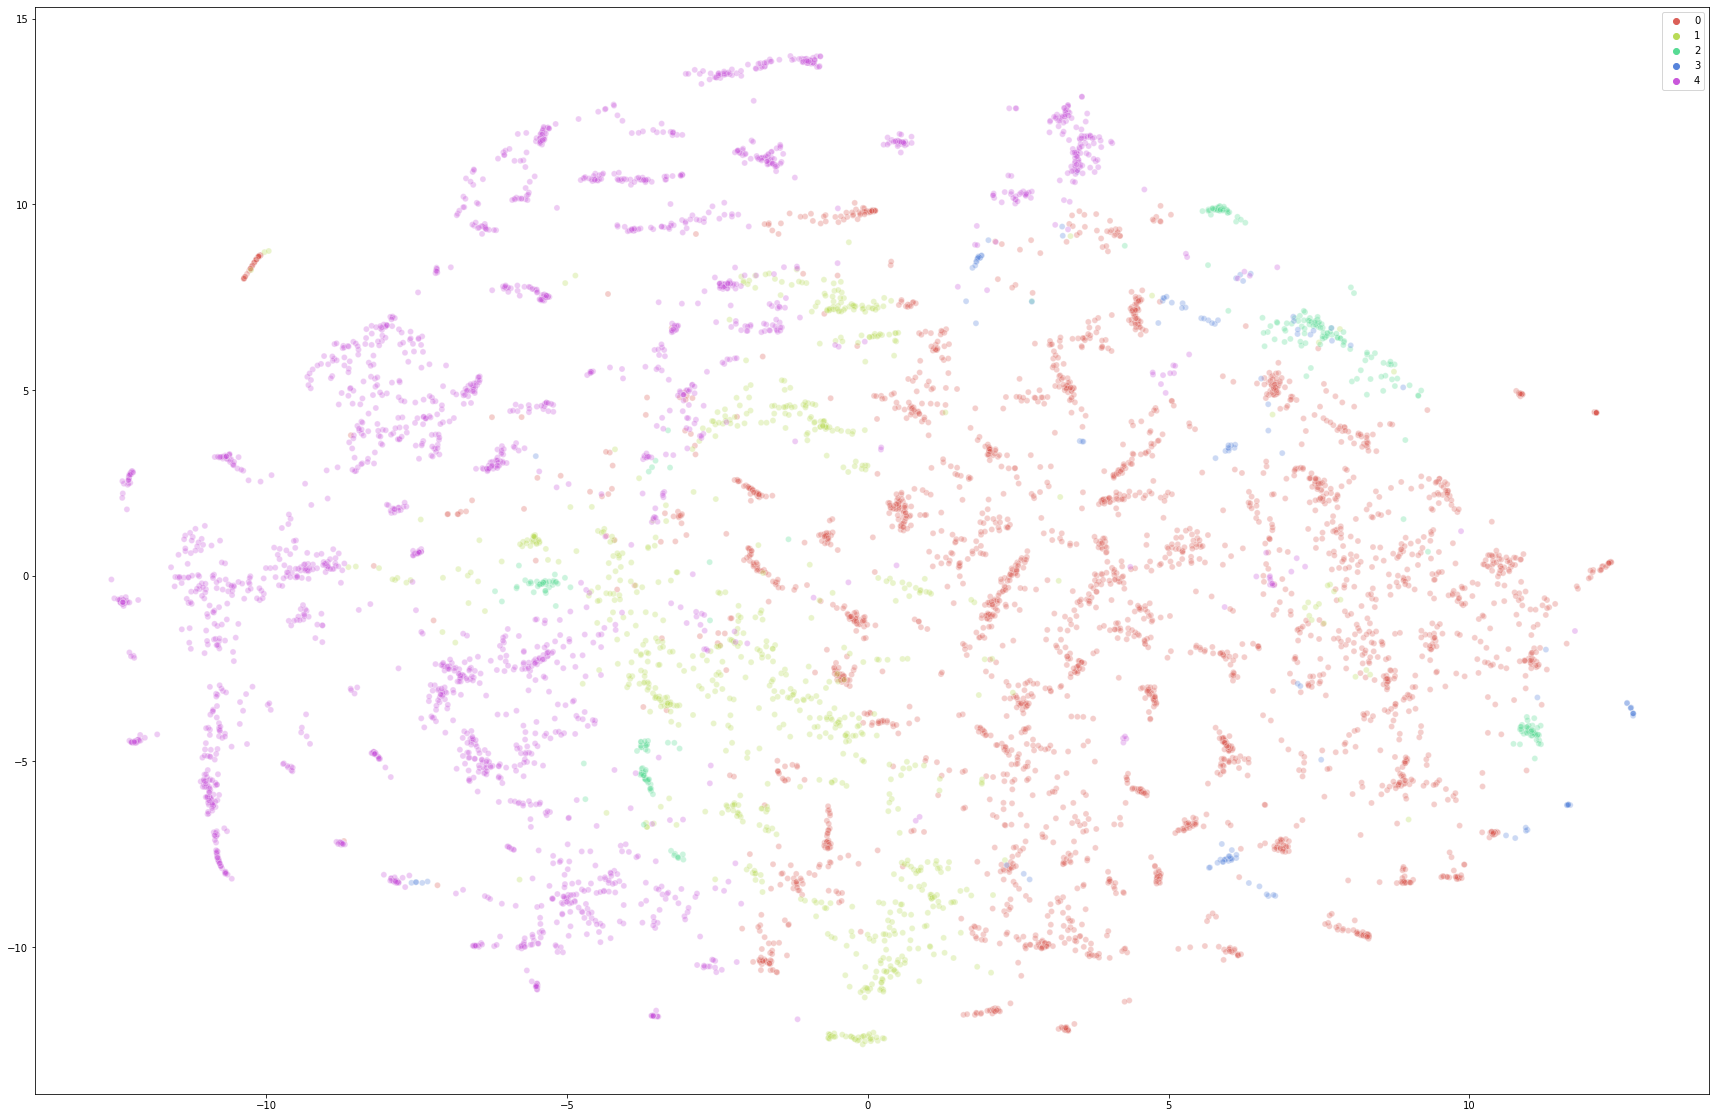

In [62]:
lab = 'label_domain'
plt.figure(figsize=(30,20))
sns.scatterplot(
    x="x", y="y",
    hue=lab,
    palette=sns.color_palette("hls", len(Counter(df[lab]))),
    data=df,
    legend="full",
    alpha=0.3
)
# print(chr(idx+97)+"_normal_abnormal_True")

In [37]:
feature_mean_sub = (feature-torch.mean(feature[y_true==0,:],axis=0))

In [38]:
from sklearn.manifold import TSNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results_mean_sub = tsne.fit_transform(to_numpy(feature_mean_sub))
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6710 samples in 19.828s...
[t-SNE] Computed neighbors for 6710 samples in 444.987s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6710
[t-SNE] Computed conditional probabilities for sample 2000 / 6710
[t-SNE] Computed conditional probabilities for sample 3000 / 6710
[t-SNE] Computed conditional probabilities for sample 4000 / 6710
[t-SNE] Computed conditional probabilities for sample 5000 / 6710
[t-SNE] Computed conditional probabilities for sample 6000 / 6710
[t-SNE] Computed conditional probabilities for sample 6710 / 6710
[t-SNE] Mean sigma: 8.139101
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.247787
[t-SNE] KL divergence after 300 iterations: 2.150865
t-SNE done! Time elapsed: 474.2626881599426 seconds


In [39]:
import pickle
with open("../tesne/tsne_results_mean_sub.pickle", "wb") as f:
    pickle.dump(tsne_results_mean_sub, f)

In [27]:
init = list(to_numpy(model.mfcc.gamma.fc).transpose()[0])
last = list(to_numpy(trained.mfcc.gamma.fc).transpose()[0])
index = list(range(16))
dff = {"Name":index,"initial":init,"learned":last}
df = pd.DataFrame(dff,columns=["Name","initial","learned"])
df["difference"] = df["initial"]-df["learned"]
df["change %"] = 100*df["difference"]/df["initial"]
df

,Name,initial,learned,difference,change %
0,0,0.000000,0.000000,0.000000,NaN
1,1,25.610565,22.498903,3.111662,12.149915
2,2,52.158070,47.865807,4.292263,8.229336
3,3,79.676888,79.407509,0.269379,0.338089
4,4,108.202576,109.276253,-1.073677,-0.992284
5,5,137.771851,138.553635,-0.781784,-0.567448
6,6,168.423004,169.771210,-1.348206,-0.800488
7,7,200.195587,199.836792,0.358795,0.179222
8,8,233.130585,232.208755,0.921829,0.395413
9,9,267.270538,267.711578,-0.441040,-0.165016


In [84]:
#old mfcc model result domain-wise
pro = [.76, .71 ,.71, .80, .96];
acc,w = result(y_pred,y_true,val_parts,domain)
print("    Current    Type IV tconv-cnn")
for c,x,p in zip('abcde',acc,pro):
    print(c+ " -   "+ "%.2f"%(x) + "          "+"%.2f"%(p))

    Current    Type IV tconv-cnn
a -   0.67          0.76
b -   0.71          0.71
c -   0.88          0.71
d -   0.65          0.80
e -   0.98          0.96


In [18]:
pro = [.76, .71 ,.71, .80, .96];
acc,w = result(y_pred,y_true,val_parts,domain)
print("    Learned mfcc    Type IV tconv-cnn")
for c,x,p in zip('abcde',acc,pro):
    print(c+ " -   "+ "%.2f"%(x) + "          "+"%.2f"%(p))

    Learned mfcc    Type IV tconv-cnn
a -   0.70          0.76
b -   0.76          0.71
c -   0.88          0.71
d -   0.65          0.80
e -   0.97          0.96


In [28]:
sum(np.multiply(acc,w))/sum(w)

0.8120715350223547

In [29]:
sum(w)

6710

In [15]:
def result(y_pred, y_val,val_parts, domain=None):
    y_pred = y_pred.cpu().detach().numpy()
    y_val = y_val.cpu().detach().numpy()   
    acc = [sum(y_pred[domain==c]==y_val[domain==c])/sum(domain==c) for c in range(5)]
    weight = [sum(domain==c) for c in range(5)]
    return acc,weight

In [6]:
from sklearn.metrics import confusion_matrix
eps = 0.0000001
def log_macc(y_pred, y_val,val_parts, val_files=None):
    y_pred = y_pred.cpu().detach().numpy()
#     y_pred_domain = y_pred_domain.cpu().detach().numpy()
    y_val = y_val.cpu().detach().numpy()
    true = []
    pred = []
    files = []
    start_idx = 0

#     y_pred = np.argmax(y_pred, axis=-1)
#     y_val = np.transpose(np.argmax(y_val, axis=-1))

    for j,s in enumerate(val_parts):

        if not s:  ## for e00032 in validation0 there was no cardiac cycle
            continue
        # ~ print "part {} start {} stop {}".format(s,start_idx,start_idx+int(s)-1)
        
        temp_ = y_val[start_idx:start_idx + int(s)]
        temp = y_pred[start_idx:start_idx + int(s)]

        if (sum(temp == 0) > sum(temp == 1)):
            pred.append(0)
        else:
            pred.append(1)

        if (sum(temp_ == 0) > sum(temp_ == 1)):
            true.append(0)
        else:
            true.append(1)

#         if val_files is not None:
#             files.append(val_files[start_idx])

        start_idx = start_idx + int(s)
    TN, FP, FN, TP = confusion_matrix(true, pred, labels=[0,1]).ravel()
    # TN = float(TN)
    # TP = float(TP)
    # FP = float(FP)
    # FN = float(FN)
    sensitivity = TP / (TP + FN + eps)
    specificity = TN / (TN + FP + eps)
    precision = TP / (TP + FP + eps)
    F1 = 2 * (precision * sensitivity) / (precision + sensitivity + eps)
    Macc = (sensitivity + specificity) / 2
    
    print("TN:",TN,"FP:",FP,"FN:",FN,"TP:",TP)
    print("Sensitivity:","%.2f"%sensitivity,"Specificity:","%.2f"%specificity,"Precision:","%.2f"%precision,end=' ')
    print("F1:", "%.2f"%F1,"MACC", "%.2f"%Macc)       
    
    return Macc,sensitivity,specificity,precision,F1
def trainLog(y_true,y_pred):
    eps = 0.0000001
    y_pred = y_pred.cpu().detach().numpy()
    y_true = y_true.cpu().detach().numpy()
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    sensitivity = TP / (TP + FN + eps)
    specificity = TN / (TN + FP + eps)
    precision = TP / (TP + FP + eps)
    F1 = 2 * (precision * sensitivity) / (precision + sensitivity + eps)
    Macc = (sensitivity + specificity) / 2
    print("TN:",TN,"FP:",FP,"FN:",FN,"TP:",TP)
    print("Sensitivity:","%.2f"%sensitivity,"Specificity:","%.2f"%specificity,"Precision:","%.2f"%precision,end=' ')
    print("F1:", "%.2f"%F1,"MACC", "%.2f"%Macc)
    